<a href="https://colab.research.google.com/github/Pietro55555/PRiR/blob/main/PRiR/Lab11/Lab11_1/Lab11_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zadaniem programu jest nadanie stylu jednego zdjęcie na drugie zdjęcie. W moim przypadku użyje słynnego obrau Mona Lisy oraz obrazu Krzyk.


Najpierw ładujemy wszystkie potrzebne pakiety i biblioteki

In [66]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
Jeśli cuda jest dostępny wykorzystujemy gpu (cude) w przeciwnym razie wykorzystamy cpu

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)



style_image jest to zdjęcie z którego pobieramy styl, a content_img to zdjęcie a który aplikujemy styl. Orginalnie ten kod poniżej powinnen być w tym wyżej ale dla wygodny zmieniłem troche kod i teraz jest odzielnie dzięki czemu łatwiej jest zmienić obraz na inny.

**UWAGA**

Oba zdjęcia muszą być tej samej wielkości

In [69]:
style_img = image_loader("krzyk.jpg")
content_img = image_loader("mona.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

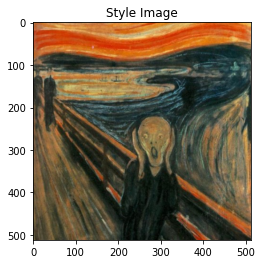

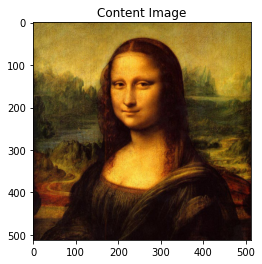

In [70]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

odłączamy zawartość docelową od drzewa używanego do dynamicznego obliczania gradientu: jest to określona wartość, a nie zmienna. W przeciwnym razie metoda forward kryterium spowoduje błąd.

In [27]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Normalizujemy wartość macierzy G dzieląc przez liczbę elementów na każdej mapie cech (b to ilość map cech)

In [28]:
def gram_matrix(input):

    a, b, c, d = input.size()  
    features = input.view(a * b, c * d)  
    G = torch.mm(features, features.t())  
    
    return G.div(a * b * c * d)

In [29]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [30]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Moduł normalizuje obraz wejściowy

In [31]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [32]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

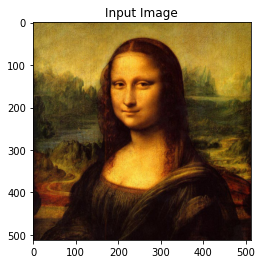

In [33]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [34]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [74]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Zmieniłem troche kod i teraz tutaj możemy ustawić ilość wykonywanych kroków. Komunikat o progresie otrzymamy co 50 krok

In [82]:
num_steps = 400

Jeśli mamy prawidłowe zdjęcia oraz dobrze ustawioną ilość stepsów (czyli liczbe) to wystarczy uruchomić okno poniżej i chwile poczekać (polecam do tego włączyć GPU)

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.366757 Content Loss: 4.476472

run [100]:
Style Loss : 0.358488 Content Loss: 4.419906

run [150]:
Style Loss : 0.358223 Content Loss: 4.367703

run [200]:
Style Loss : 0.353355 Content Loss: 4.310392

run [250]:
Style Loss : 0.347258 Content Loss: 4.257738

run [300]:
Style Loss : 0.342029 Content Loss: 4.200652

run [350]:
Style Loss : 0.339399 Content Loss: 4.148595

run [400]:
Style Loss : 0.340099 Content Loss: 4.095410



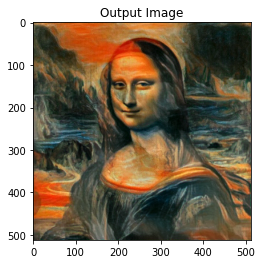

In [83]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps)

#plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()